In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import minmax_scale, LabelEncoder
import seaborn as sns

%matplotlib inline

In [41]:
from normalize_component import normalize_component

In [42]:
raw = pd.read_csv('tidy.csv', delimiter=';', parse_dates=['date'])

In [43]:
raw.head(6)

,turma,date,student,satisfaction,pace,relevance,component,learn
0,S0219,2019-04-18 00:00:00+03:00,Aluno 25,7.0,3.0,4.0,aplicações de clusterização de dados,1.0
1,S0219,2019-04-18 00:00:00+03:00,Aluno 25,7.0,3.0,4.0,MeanShift e DBSCAN,2.0
2,S0219,2019-04-18 00:00:00+03:00,Aluno 47,8.0,4.0,5.0,aplicações de clusterização de dados,1.0
3,S0219,2019-04-18 00:00:00+03:00,Aluno 47,8.0,4.0,5.0,MeanShift e DBSCAN,2.0
4,S0219,2019-04-18 00:00:00+03:00,Aluno 32,6.0,4.0,4.0,aplicações de clusterização de dados,1.0
5,S0219,2019-04-18 00:00:00+03:00,Aluno 32,6.0,4.0,4.0,MeanShift e DBSCAN,1.0


In [44]:
raw.dtypes

turma                                          object
date            datetime64[ns, pytz.FixedOffset(180)]
student                                        object
satisfaction                                  float64
pace                                          float64
relevance                                     float64
component                                      object
learn                                         float64
dtype: object

In [45]:
raw = raw[raw.turma.apply(lambda t: t[0] == 'A' or t[0] == 'S')].dropna()
#raw = raw[raw.learn >= 0]

In [46]:
turma_encoder = LabelEncoder()
turma_encoder.fit(raw.turma)

df = pd.DataFrame(data={
    # Curso: Data Analytics (DA) ou Data Science (DS)
    'course': raw.turma.apply(lambda t: 'DA' if t[0] == 'A' else 'DS'),
    
    # A turma (só o número)
    'turma': turma_encoder.transform(raw.turma),
    
    # Apenas a data
    'date': raw.date.apply(lambda t: t.date()),
        
    # O ID do aluno (só o número)
    'student': raw.student.apply(lambda s: int(re.search('Aluno (\d*)', s, re.IGNORECASE).group(1))),
    
    # Componente de conhecimento
    'topicos': raw.component.apply(lambda text: re.sub(' +', ' ', text).replace("'s", '')),
    
    # Componente de conhecimento
    'component': raw.component.apply(normalize_component),
    
    # Relevância, normalizada no intervalo [0,1]
    'relevance': minmax_scale(raw.relevance, (0,10)).astype(np.int32),
    
    # Aprendizagem
    'learn': raw.learn.astype(np.int32),
    
    # Satisfação, normalizada no intervalo [0,1]
    'satisfaction': minmax_scale(raw.satisfaction, (0,10)).astype(np.int32),
    
    # Ritmo, normalizado no intervalo [0,1]
    'pace': minmax_scale(raw.pace, (0,10)).astype(np.int32),
})

# Atributo "Ferramenta"

A partir da componente de cada amostra, deduzimos se a amostra refere-se a uma aula que envolveu ferramenta ou não.

In [47]:
@np.vectorize
def tool(component):
    return 'Ferramenta' in component

In [48]:
df.loc[:,'tool'] = df.component.apply(tool)

# Atributo "Algoritmo"

A partir da componente de cada amostra, deduzimos se a amostra refere-se a uma aula que envolveu algoritmo ou não.

In [49]:
@np.vectorize
def algorithm(component):
    return 'Algoritmo' in component and 'ML' in component

In [50]:
df.loc[:,'algorithm'] = df.component.apply(algorithm)

In [51]:
df.head()

,course,turma,date,student,topicos,component,relevance,learn,satisfaction,pace,tool,algorithm
0,DS,6,2019-04-18,25,aplicações de clusterização de dados,Agrupamento,4,1,6,5,False,False
1,DS,6,2019-04-18,25,MeanShift e DBSCAN,Agrupamento/Algoritmo/ML,4,2,6,5,False,True
2,DS,6,2019-04-18,47,aplicações de clusterização de dados,Agrupamento,5,1,7,7,False,False
3,DS,6,2019-04-18,47,MeanShift e DBSCAN,Agrupamento/Algoritmo/ML,5,2,7,7,False,True
4,DS,6,2019-04-18,32,aplicações de clusterização de dados,Agrupamento,4,1,5,7,False,False


In [52]:
da=df[df.course == 'DS']
da[~da.algorithm].head()

,course,turma,date,student,topicos,component,relevance,learn,satisfaction,pace,tool,algorithm
0,DS,6,2019-04-18,25,aplicações de clusterização de dados,Agrupamento,4,1,6,5,False,False
2,DS,6,2019-04-18,47,aplicações de clusterização de dados,Agrupamento,5,1,7,7,False,False
4,DS,6,2019-04-18,32,aplicações de clusterização de dados,Agrupamento,4,1,5,7,False,False
6,DS,6,2019-04-18,23,aplicações de clusterização de dados,Agrupamento,5,2,10,5,False,False
8,DS,6,2019-04-18,17,aplicações de clusterização de dados,Agrupamento,5,1,6,7,False,False


# Exportação

Encerramos esse pré-processamento exportando o conjunto de dados, segmentado por curso, para processamento especializado posterior. Primeiramente, Data Science:

In [53]:
ds = df[df.course == 'DS']
ds.drop(['course'], axis=1).to_csv('ds_tidy.csv', index=False)

Em seguida, Data Analytics:

In [54]:
da = df[df.course == 'DA']
da.drop(['course'], axis=1).to_csv('da_tidy.csv', index=False)

# Wordcloud

O objetivo é identificar termos mais comuns. Usei NLP para considerar apenas lemmas.
Inspiração: [aqui](https://www.unece.org/fileadmin/DAM/stats/documents/ece/ces/ge.44/2018/T_USA_Martinez_Paper.pdf)

In [18]:
import spacy
nlp = spacy.load('pt')

In [34]:
BAG_MEMENTO_FILENAME = 'da_bow.pickle'

In [ ]:
# Carrega o bag...
bag = pickle.load(open(BAG_MEMENTO_FILENAME, 'rb'))

In [35]:
#... ou cria
bag = []

for component in da.topicos.iloc:
    doc = nlp(component)
    bag += [token.lemma_.lower() for token in doc if token.pos_ not in ['AUX', 'ADP']]

In [50]:
component = da.topicos.iloc[3077]
component = component.replace('dados', 'datum')
doc = nlp(component)
[(token.lemma_.lower(), token.pos_) for token in doc if token.pos_ not in ['AUX', 'ADP', 'PUNCT']]

[('importância', 'NOUN'),
 ('do', 'DET'),
 ('pensamento', 'NOUN'),
 ('negócio', 'NOUN'),
 ('data', 'PROPN'),
 ('analytics', 'PROPN')]

In [36]:
# Save o bag
import pickle
pickle.dump(bag, open(BAG_MEMENTO_FILENAME, 'wb'))

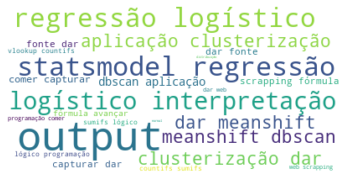

In [41]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# Generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(' '.join(bag))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
wordcloud.to_file("img/wordcloud.png")

36

In [23]:

set(df.component)

{'?',
 'API (dev)',
 'Agile',
 'Agrupamento',
 'Agrupamento/Algoritmo/ML',
 'Amostra',
 'Análise',
 'Aplicação',
 'Arquitetura de dados',
 'Avaliação',
 'Avaliação/Modelagem',
 'Avaliação/Métricas/Modelagem',
 'Banco de dados',
 'Bancos de dados',
 'Bancos de dados/Ferramenta',
 'Boosting',
 'Classificação',
 'Classificação/Algoritmo/ML',
 'Classificação/Aplicação',
 'Classificação/Otimização',
 'Compressão de dados',
 'Compressão de dados/Algoritmo/ML',
 'Cultura de dados',
 'Cultura de dados/Aplicação',
 'Data Analytics',
 'Data Analytics/Frameworks',
 'Data Analytics/Negócios',
 'Data Analytics/Research',
 'Data Analytics/Tendências',
 'Data Analytics/métricas',
 'Data cleaning',
 'Data compression',
 'Data compression/Algoritmo',
 'Data compression/Algoritmo/ML',
 'Data manipulation/Ferramenta',
 'Data mining/Ferramenta',
 'Data preparation',
 'Data transformation',
 'Data transformation/Ferramenta',
 'Data wrangling',
 'DataViz',
 'DataViz/Ferramenta',
 'DataViz/Storytelling',
 'D